https://www.kaggle.com/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset

In [ ]:
import os
import shutil
from pathlib import Path
import random
import yaml
from PIL import Image

# Organize dataset into YOLO format with proper image and label structure
def prepare_dataset(base_path, train_ratio=0.75):
    # Create directory structure
    train_dir = Path(base_path) / 'train' / 'images'
    val_dir = Path(base_path) / 'val' / 'images'
    train_labels = Path(base_path) / 'train' / 'labels'
    val_labels = Path(base_path) / 'val' / 'labels'

    # Create all directories
    for d in [train_dir, val_dir, train_labels, val_labels]:
        d.mkdir(exist_ok=True, parents=True)

    # Clean existing cache files
    for cache_file in Path(base_path).glob('*.cache'):
        cache_file.unlink()

    # Get letter directories and create class mapping
    letter_dirs = [d for d in os.listdir(base_path)
                  if os.path.isdir(os.path.join(base_path, d))
                  and d not in ['train', 'val']]
    class_mapping = {letter: idx for idx, letter in enumerate(sorted(letter_dirs))}

    processed_images = 0
    skipped_images = 0

    for letter in letter_dirs:
        letter_path = Path(base_path) / letter
        images = [f for f in letter_path.glob(f"{letter}_*.jpg")]

        # Shuffle and split images
        random.shuffle(images)
        split_idx = int(len(images) * train_ratio)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Process training images
        for img in train_images:
            try:
                # Verify image integrity
                with Image.open(img) as im:
                    width, height = im.size
                    # Normalize bounding box coordinates
                    x_center, y_center = 0.5, 0.5
                    box_width, box_height = 0.8, 0.8

                # Copy image
                shutil.copy2(img, train_dir / img.name)

                # Create label file
                label_path = train_labels / f"{img.stem}.txt"
                with open(label_path, 'w') as f:
                    f.write(f"{class_mapping[letter]} {x_center} {y_center} {box_width} {box_height}\n")

                processed_images += 1
            except Exception as e:
                print(f"Skipping corrupt image {img}: {str(e)}")
                skipped_images += 1
                continue

        # Process validation images
        for img in val_images:
            try:
                with Image.open(img) as im:
                    width, height = im.size
                    x_center, y_center = 0.5, 0.5
                    box_width, box_height = 0.8, 0.8

                shutil.copy2(img, val_dir / img.name)

                label_path = val_labels / f"{img.stem}.txt"
                with open(label_path, 'w') as f:
                    f.write(f"{class_mapping[letter]} {x_center} {y_center} {box_width} {box_height}\n")

                processed_images += 1
            except Exception as e:
                print(f"Skipping corrupt image {img}: {str(e)}")
                skipped_images += 1
                continue

        print(f"Processed {letter}: {len(train_images)} train, {len(val_images)} val")

    # Create YAML configuration
    yaml_config = {
        'path': str(Path(base_path)),
        'train': 'train/images',  # Updated paths
        'val': 'val/images',
        'names': sorted(letter_dirs),
        'nc': len(letter_dirs)
    }

    yaml_path = Path(base_path) / 'data.yaml'
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.safe_dump(yaml_config, f, sort_keys=False, allow_unicode=True)

    print(f"\nDataset preparation complete:")
    print(f"- Processed {processed_images} images")
    print(f"- Skipped {skipped_images} corrupt images")
    print(f"- Created {len(letter_dirs)} classes")
    print(f"- YAML configuration saved to {yaml_path}")

    return str(yaml_path)

dataset_path = "rgb-arabic-alphabets-sign-language-dataset/versions/4/RGB ArSL dataset"
data_yaml_path = prepare_dataset(dataset_path)

Processed Ain: 153 train, 52 val
Processed Al: 176 train, 59 val
Processed Alef: 183 train, 62 val
Processed Beh: 194 train, 65 val
Processed Dad: 171 train, 57 val
Processed Dal: 147 train, 49 val
Processed Feh: 163 train, 55 val
Processed Ghain: 144 train, 48 val
Processed Hah: 150 train, 50 val
Processed Heh: 164 train, 55 val
Processed Jeem: 132 train, 44 val
Processed Kaf: 168 train, 57 val
Processed Khah: 154 train, 52 val
Processed Laa: 171 train, 58 val
Processed Lam: 168 train, 57 val
Processed Meem: 160 train, 54 val
Processed Noon: 147 train, 50 val
Processed Qaf: 140 train, 47 val
Processed Reh: 139 train, 47 val
Processed Sad: 173 train, 58 val
Processed Seen: 169 train, 57 val
Processed Sheen: 177 train, 60 val
Processed Tah: 141 train, 47 val
Processed Teh: 195 train, 66 val
Processed Teh_Marbuta: 165 train, 56 val
Processed Thal: 123 train, 41 val
Processed Theh: 195 train, 65 val
Processed Waw: 158 train, 53 val
Processed Yeh: 174 train, 59 val
Processed Zah: 144 train

In [ ]:
import torch
from pathlib import Path
import os, sys

dataset_path = "rgb-arabic-alphabets-sign-language-dataset/versions/4/RGB ArSL dataset"
data_yaml_path = os.path.join(dataset_path, "data.yaml")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")
print(f"Torch version: {torch.version.__version__}")
print(f"Python version: {sys.version}")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3070
Torch version: 2.5.0+cu124
Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [ ]:
from ultralytics import YOLO
# Load a model
model = YOLO("yolo11n.pt")

# Set environment variable properly
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Train the model
train_results = model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=832,
    batch=32,
    workers=2,
    device=0,
    project="runs/train",
    name="yolov11_raasld",
    exist_ok=True,
    save_period=5,
    patience=5,
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=5,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    amp=True,
    close_mosaic=10,
    augment=True,
    mixup=0.1,
    copy_paste=0.1,
)

Ultralytics 8.3.84  Python-3.11.0 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=F:/Projects/ArSL_Project/rgb-arabic-alphabets-sign-language-dataset/versions/4/RGB ArSL dataset\data.yaml, epochs=50, time=None, patience=5, batch=32, imgsz=832, save=True, save_period=5, cache=False, device=0, workers=2, project=runs/train, name=yolov11_raasld, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning F:\Projects\ArSL_Project\rgb-arabic-alphabets-sign-language-dataset\versions\4\RGB ArSL dataset\train\labels... 6039 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6039/6039 [00:04<00:00, 1244.70it/s]


train: New cache created: F:\Projects\ArSL_Project\rgb-arabic-alphabets-sign-language-dataset\versions\4\RGB ArSL dataset\train\labels.cache


val: Scanning F:\Projects\ArSL_Project\rgb-arabic-alphabets-sign-language-dataset\versions\4\RGB ArSL dataset\val\labels... 2752 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2752/2752 [00:02<00:00, 1185.12it/s]


val: New cache created: F:\Projects\ArSL_Project\rgb-arabic-alphabets-sign-language-dataset\versions\4\RGB ArSL dataset\val\labels.cache
Plotting labels to runs\train\yolov11_raasld\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 832 train, 832 val
Using 2 dataloader workers
Logging results to runs\train\yolov11_raasld
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.45G     0.8424      3.402      1.553         79        832: 100%|██████████| 189/189 [31:36<00:00, 10.03s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [07:10<00:00, 10.01s/it]

                   all       2752       2752     0.0379      0.758     0.0581     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.39G     0.6602      2.424      1.323         67        832: 100%|██████████| 189/189 [04:45<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:04<00:00,  1.50s/it]

                   all       2752       2752      0.218      0.531       0.28      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.42G     0.6056      2.031      1.264         63        832: 100%|██████████| 189/189 [14:21<00:00,  4.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [04:02<00:00,  5.65s/it]

                   all       2752       2752      0.452        0.6      0.492      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.47G     0.5582      1.797      1.226         70        832: 100%|██████████| 189/189 [11:55<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [03:28<00:00,  4.85s/it]

                   all       2752       2752      0.472      0.589      0.512      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       7.4G     0.5594      1.642      1.225         76        832: 100%|██████████| 189/189 [12:22:31<00:00, 235.72s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:09<00:00,  1.62s/it]

                   all       2752       2752      0.548      0.683      0.684      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.47G     0.5454      1.594      1.212         85        832: 100%|██████████| 189/189 [03:31<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       2752       2752      0.659      0.746      0.775      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.47G     0.5249      1.484      1.196         55        832: 100%|██████████| 189/189 [03:20<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:23<00:00,  1.93s/it]

                   all       2752       2752      0.845      0.804      0.892      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.46G     0.5085      1.424      1.184         77        832: 100%|██████████| 189/189 [03:20<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:41<00:00,  1.03it/s]

                   all       2752       2752      0.781      0.816      0.874      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.47G     0.4884      1.373      1.165         65        832: 100%|██████████| 189/189 [03:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:04<00:00,  1.49s/it]

                   all       2752       2752      0.818      0.827      0.904      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.41G     0.4744      1.302      1.157         70        832: 100%|██████████| 189/189 [03:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:39<00:00,  1.08it/s]

                   all       2752       2752      0.912      0.868      0.954      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       7.4G      0.467      1.267      1.148         81        832: 100%|██████████| 189/189 [03:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:05<00:00,  1.51s/it]

                   all       2752       2752      0.897      0.895      0.936      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.46G     0.4589      1.251       1.14         76        832: 100%|██████████| 189/189 [03:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:40<00:00,  1.07it/s]

                   all       2752       2752      0.914      0.911      0.963      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.47G     0.4525      1.234      1.134         71        832: 100%|██████████| 189/189 [03:21<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:05<00:00,  1.53s/it]

                   all       2752       2752      0.947      0.948       0.98      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.46G     0.4411      1.198      1.126         68        832: 100%|██████████| 189/189 [03:20<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:40<00:00,  1.07it/s]

                   all       2752       2752      0.931      0.914      0.973      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.46G      0.438      1.162      1.124         69        832: 100%|██████████| 189/189 [03:27<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:12<00:00,  1.68s/it]

                   all       2752       2752      0.932      0.933      0.979      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.46G     0.4291      1.131       1.12         69        832: 100%|██████████| 189/189 [03:21<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:40<00:00,  1.06it/s]

                   all       2752       2752      0.942      0.926      0.978       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.46G     0.4247      1.133      1.116         71        832: 100%|██████████| 189/189 [03:39<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:44<00:00,  2.44s/it]

                   all       2752       2752      0.955      0.948      0.983       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.46G     0.4153      1.113      1.107         74        832: 100%|██████████| 189/189 [03:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:44<00:00,  1.03s/it]

                   all       2752       2752      0.929      0.946       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.47G      0.415      1.086      1.107         78        832: 100%|██████████| 189/189 [03:33<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:04<00:00,  1.50s/it]

                   all       2752       2752      0.968      0.961      0.988      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.46G     0.4113       1.07      1.104         69        832: 100%|██████████| 189/189 [03:29<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:53<00:00,  1.23s/it]

                   all       2752       2752      0.972      0.965      0.988      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       7.4G     0.4023      1.058      1.097         73        832: 100%|██████████| 189/189 [04:13<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [03:37<00:00,  5.05s/it]

                   all       2752       2752      0.955      0.955      0.986       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.41G     0.4023      1.053      1.102         74        832: 100%|██████████| 189/189 [04:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:42<00:00,  1.02it/s]

                   all       2752       2752      0.938      0.954      0.982      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.47G      0.396      1.029      1.091         67        832: 100%|██████████| 189/189 [04:49<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:45<00:00,  2.46s/it]

                   all       2752       2752      0.969      0.961      0.987      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.46G     0.3981      1.032      1.093         70        832: 100%|██████████| 189/189 [04:28<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:05<00:00,  2.93s/it]

                   all       2752       2752      0.976      0.974      0.989      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.47G     0.3857      1.003      1.087         71        832: 100%|██████████| 189/189 [05:42<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:54<00:00,  2.66s/it]

                   all       2752       2752       0.98      0.979      0.992      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       7.4G     0.3862     0.9981      1.083         74        832: 100%|██████████| 189/189 [09:16<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:52<00:00,  4.00s/it]

                   all       2752       2752      0.975      0.972      0.991      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       7.4G     0.3811      0.979      1.083         69        832: 100%|██████████| 189/189 [05:29<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:22<00:00,  3.31s/it]

                   all       2752       2752      0.971      0.976      0.991      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.46G     0.3851     0.9625      1.086         83        832: 100%|██████████| 189/189 [04:53<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:07<00:00,  1.57s/it]

                   all       2752       2752      0.987      0.977      0.992      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       7.4G     0.3728     0.9536      1.076         78        832: 100%|██████████| 189/189 [04:43<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:41<00:00,  3.77s/it]

                   all       2752       2752      0.982      0.978      0.991      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.46G     0.3692     0.9565      1.075         75        832: 100%|██████████| 189/189 [08:24<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:09<00:00,  1.62s/it]

                   all       2752       2752      0.984      0.979      0.992      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.46G       0.37     0.9485      1.075         72        832: 100%|██████████| 189/189 [05:07<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:13<00:00,  1.70s/it]

                   all       2752       2752      0.982       0.98      0.992      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.46G     0.3619     0.9286      1.068         75        832: 100%|██████████| 189/189 [06:13<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:52<00:00,  2.62s/it]

                   all       2752       2752      0.988      0.988      0.992      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.41G     0.3605     0.9192      1.065         67        832: 100%|██████████| 189/189 [06:29<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:09<00:00,  3.02s/it]

                   all       2752       2752      0.985      0.985      0.992      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.46G     0.3548     0.9105      1.061         65        832: 100%|██████████| 189/189 [10:15<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:20<00:00,  3.26s/it]

                   all       2752       2752      0.987      0.983      0.992      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.47G     0.3537     0.9051      1.061         62        832: 100%|██████████| 189/189 [08:26<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:53<00:00,  2.65s/it]

                   all       2752       2752      0.987      0.986      0.992      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.46G     0.3537      0.905      1.061         81        832: 100%|██████████| 189/189 [25:59<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [03:27<00:00,  4.83s/it]

                   all       2752       2752      0.985       0.99      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.47G     0.3414     0.8788      1.053         59        832: 100%|██████████| 189/189 [07:55<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [06:04<00:00,  8.47s/it]

                   all       2752       2752      0.989      0.988      0.993      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.4G     0.3396     0.8794      1.053         77        832: 100%|██████████| 189/189 [08:48<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:10<00:00,  3.04s/it]

                   all       2752       2752      0.988      0.991      0.993      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       7.4G     0.3336      0.884      1.047         68        832: 100%|██████████| 189/189 [08:06<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [03:12<00:00,  4.48s/it]

                   all       2752       2752      0.989       0.98      0.993      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       7.4G     0.3302     0.8667      1.046         84        832: 100%|██████████| 189/189 [09:33<00:00,  3.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:22<00:00,  3.30s/it]

                   all       2752       2752      0.992      0.988      0.993      0.991


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.36G     0.3122      0.263      1.137         23        832: 100%|██████████| 189/189 [05:44<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [03:51<00:00,  5.38s/it]

                   all       2752       2752       0.99      0.985      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.36G     0.2876     0.2214      1.118         23        832: 100%|██████████| 189/189 [09:49<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:42<00:00,  3.77s/it]

                   all       2752       2752       0.99      0.984      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.36G     0.2707     0.2074      1.094         23        832: 100%|██████████| 189/189 [07:07<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:24<00:00,  3.36s/it]

                   all       2752       2752       0.99      0.988      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.36G     0.2683     0.2053      1.091         23        832: 100%|██████████| 189/189 [05:12<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:25<00:00,  2.00s/it]

                   all       2752       2752      0.989       0.99      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.36G     0.2661     0.2006      1.094         23        832: 100%|██████████| 189/189 [03:44<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:36<00:00,  3.64s/it]

                   all       2752       2752      0.991      0.988      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.36G      0.249     0.1857      1.075         23        832: 100%|██████████| 189/189 [03:51<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:28<00:00,  2.06s/it]

                   all       2752       2752       0.99      0.992      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.36G      0.239     0.1745      1.064         23        832: 100%|██████████| 189/189 [05:01<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [02:53<00:00,  4.02s/it]

                   all       2752       2752      0.992      0.989      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.36G      0.238     0.1725      1.063         23        832: 100%|██████████| 189/189 [04:31<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:20<00:00,  1.88s/it]

                   all       2752       2752       0.99      0.992      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.36G     0.2308     0.1642      1.055         23        832: 100%|██████████| 189/189 [03:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [01:23<00:00,  1.95s/it]

                   all       2752       2752      0.992       0.99      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.36G        inf     0.1665      1.059         23        832: 100%|██████████| 189/189 [02:57<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       2752       2752      0.993      0.991      0.994      0.994



50 epochs completed in 19.353 hours.
Optimizer stripped from runs\train\yolov11_raasld\weights\last.pt, 5.5MB
Optimizer stripped from runs\train\yolov11_raasld\weights\best.pt, 5.5MB

Validating runs\train\yolov11_raasld\weights\best.pt...
Ultralytics 8.3.84  Python-3.11.0 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
YOLO11n summary (fused): 100 layers, 2,588,197 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:36<00:00,  1.17it/s]


                   all       2752       2752      0.992      0.993      0.994      0.993
                   Ain         90         90      0.999          1      0.995      0.994
                    Al        101        101      0.999          1      0.995      0.995
                  Alef        101        101      0.999          1      0.995      0.995
                   Beh        112        112      0.982          1      0.995      0.994
                   Dad         98         98       0.99          1      0.995      0.994
                   Dal         86         86      0.998      0.988       0.99      0.989
                   Feh         97         97      0.979       0.99      0.995      0.995
                 Ghain         84         84      0.999          1      0.995      0.994
                   Hah         86         86      0.965          1      0.983      0.983
                   Heh         95         95       0.99          1      0.995      0.995
                  Jee

In [5]:
# Save best model checkpoint
model.export(format="onnx", imgsz=832)

Ultralytics 8.3.84  Python-3.11.0 torch-2.5.0+cu124 CPU (AMD Ryzen 5 5600X 6-Core Processor)
YOLO11n summary (fused): 100 layers, 2,588,197 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs\train\yolov11_raasld\weights\best.pt' with input shape (1, 3, 832, 832) BCHW and output shape(s) (1, 35, 14196) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 26.1 MB/s eta 0:00:00
   --------------------------------------- 279.7/279.7 MB 25.0 MB/s eta 0:00:00

requirements: AutoUpdate success  35.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  36.8s, saved as 'runs\train\yolov11_raasld\weights\best.onnx' (10.2 MB)

Export complete (

'runs\\train\\yolov11_raasld\\weights\\best.onnx'

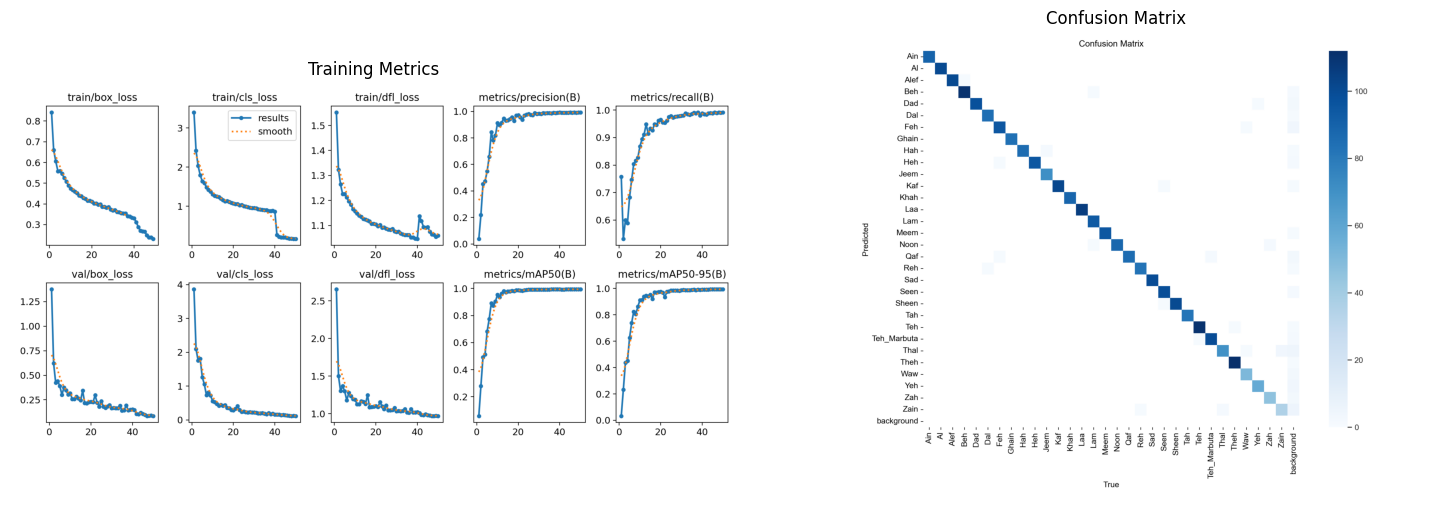


Training Batches:


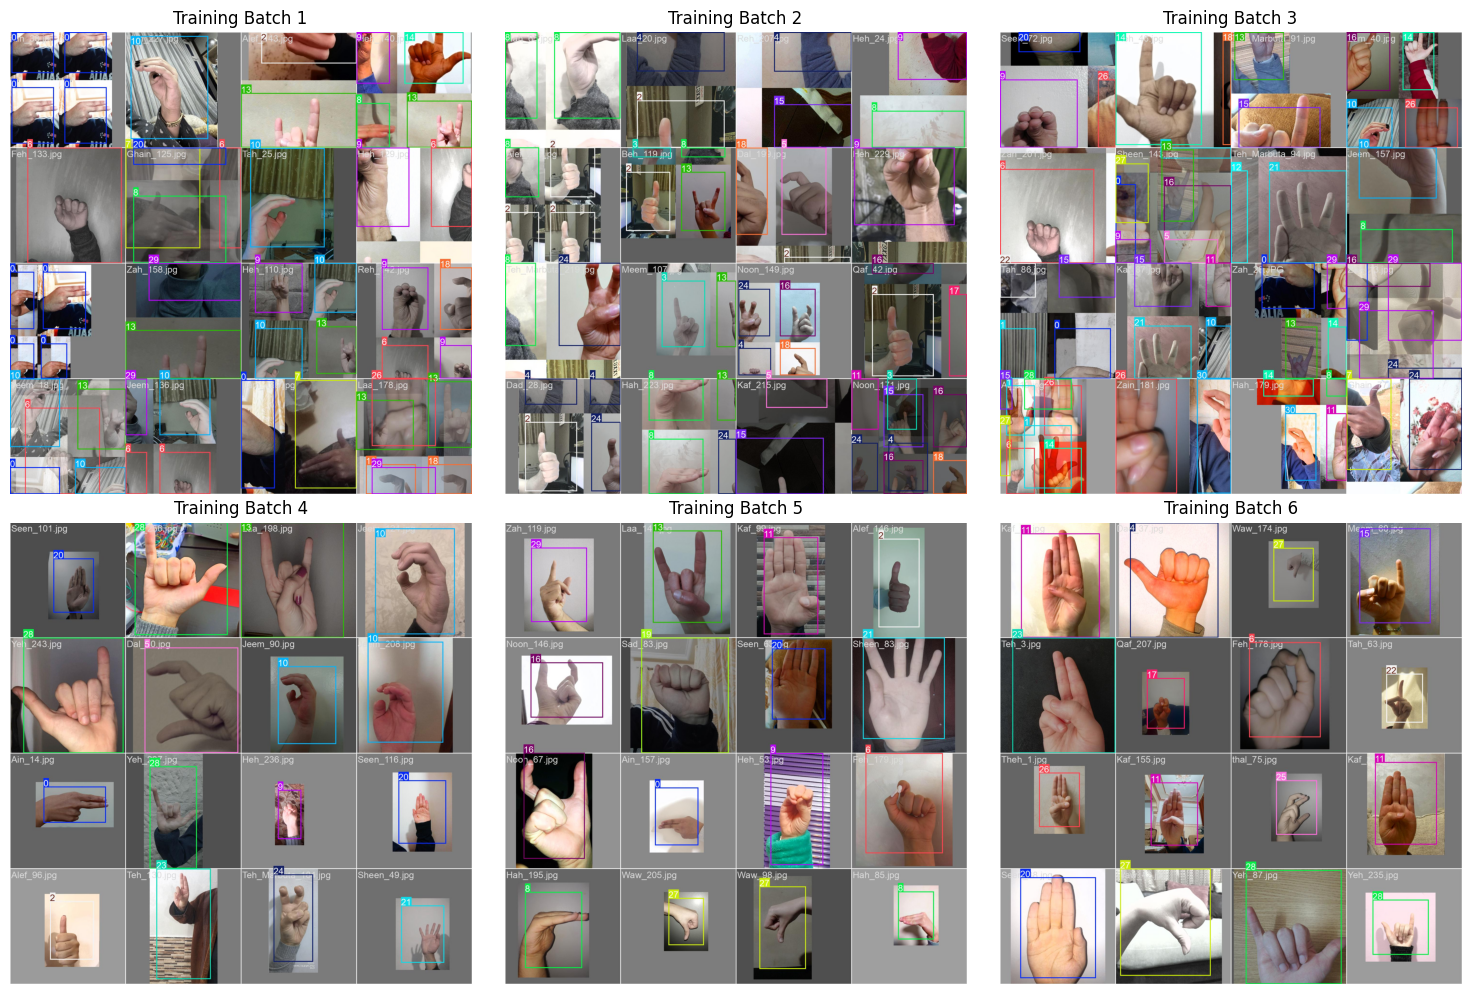


Validation Batches:


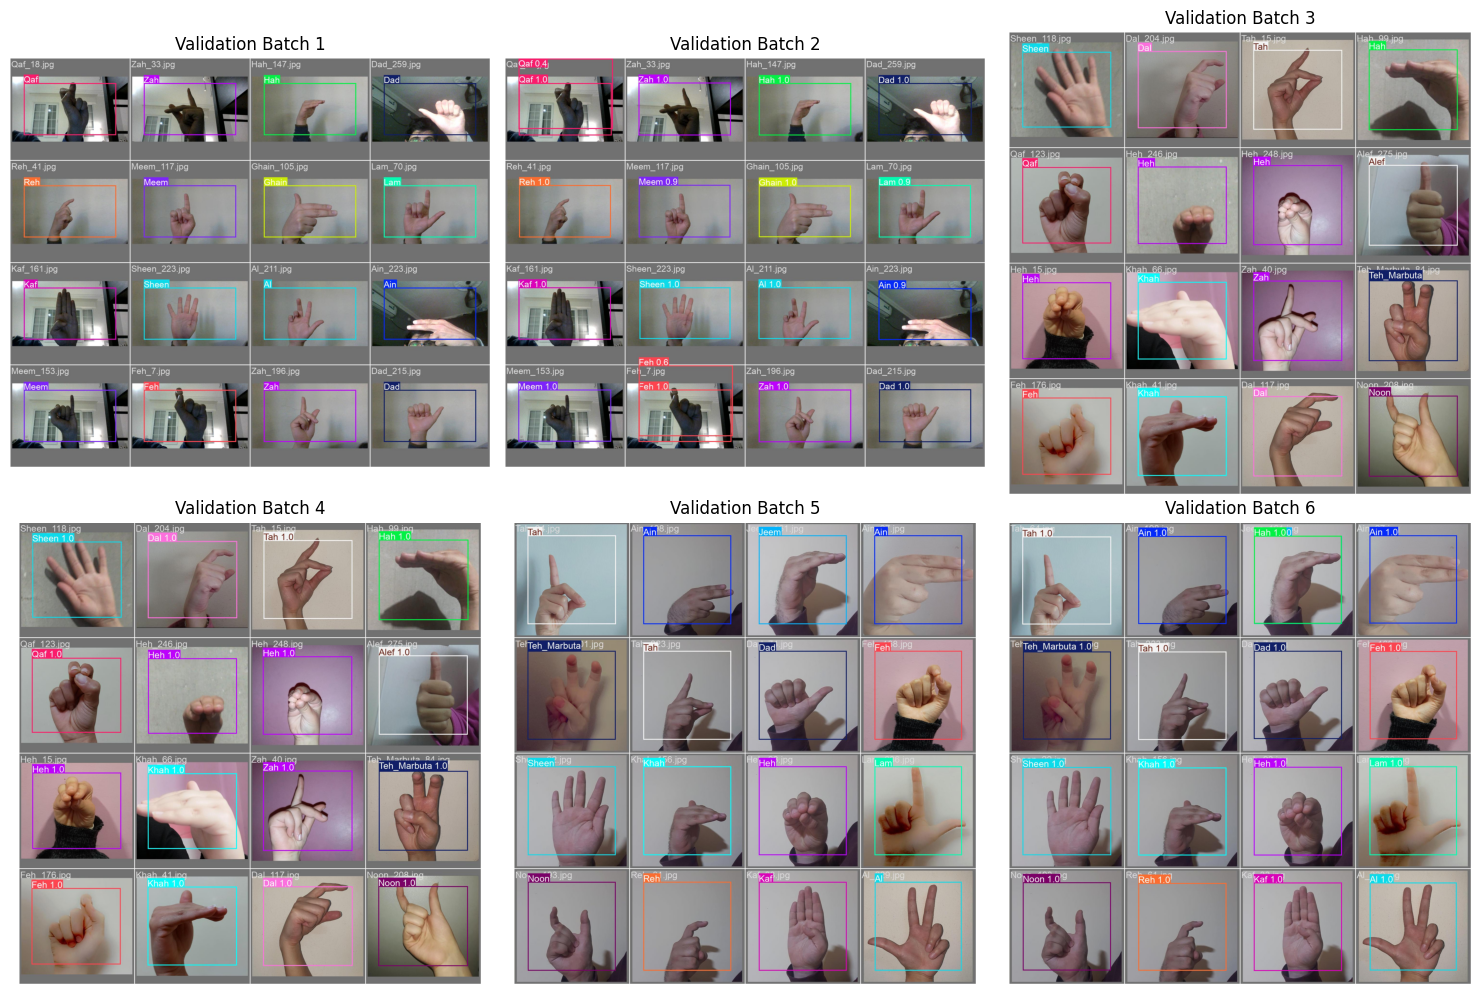

In [5]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def display_all_training_results():
    # Define path
    results_dir = Path("F:/Projects/ArSL_Project/runs/train/yolov11_raasld")

    # Collect all images
    train_batches = sorted([f for f in results_dir.glob("train_batch*.jpg")])
    val_batches = sorted([f for f in results_dir.glob("val_batch*.jpg")])

    # Display training metrics and confusion matrix
    special_files = {
        "Training Metrics": "results.png",
        "Confusion Matrix": "confusion_matrix.png"
    }

    # Plot special files first
    plt.figure(figsize=(15, 10))
    for idx, (title, filename) in enumerate(special_files.items(), 1):
        if (results_dir / filename).exists():
            plt.subplot(2, 2, idx)
            img = Image.open(results_dir / filename)
            plt.imshow(img)
            plt.title(title)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Display all training batches
    if train_batches:
        print("\nTraining Batches:")
        n_train = len(train_batches)
        cols = 3
        rows = (n_train + cols - 1) // cols
        plt.figure(figsize=(15, 5*rows))

        for idx, img_path in enumerate(train_batches, 1):
            plt.subplot(rows, cols, idx)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"Training Batch {idx}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Display all validation batches
    if val_batches:
        print("\nValidation Batches:")
        n_val = len(val_batches)
        cols = 3
        rows = (n_val + cols - 1) // cols
        plt.figure(figsize=(15, 5*rows))

        for idx, img_path in enumerate(val_batches, 1):
            plt.subplot(rows, cols, idx)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"Validation Batch {idx}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Execute the function
display_all_training_results()